In [1]:
## %%# General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from time import time
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt
import multiprocess as mp
from IPython.display import display

# Scientific and data
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
from functools import partial
eps = np.finfo(np.float).eps

# pytorch
import torch , torchvision
import torch.utils.data
import torch.nn as nn
from torch import functional as F
from torch import Tensor
torch.manual_seed(8318)


# Local modules
import  global_settings as gs
import data_loader as dl
import preprocessing as prep
from utils import create_and_configer_logger
from miscLidar import calc_extiction_klett
# %%

def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

Generate daily dataset of beta aerosol - PLAN:
from the molecular dataset load: (saved as: 2017_09_18_Haifa_molecular.nc)
1. $Pr^2$  (generated from LC*attbsc)
2. $\sigma_m$ (generated from radiosondes)
3. $\beta_m$
3. $r_{mid}$ - from the ds_day (the dataset generated above)

In [2]:
station_name = 'haifa'
station = gs.Station ( stations_csv_path = 'stations.csv' , station_name = station_name )
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 )
ds_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.nc"
ds_extended = prep.load_dataset ( ds_path_extended)
wavelengths = [355,532,1064]
#ds_extended

In [3]:
# %%
df_times = ds_extended.Time.to_pandas()
time_00 = datetime.today().time().min
days = [datetime.combine(day,time_00) for day in sorted(df_times.groupby(df_times.dt.date).groups.keys())]
day_number = 10
day = days[day_number]
day_str = day.strftime('%Y-%m-%d')
end_day= day + timedelta(hours = 24) - timedelta(seconds = 30)
slice_day = slice(day,end_day)
ds_day = ds_extended.sel(Time = slice_day).copy(deep = True)
# %%

In [4]:
# %%
time_indx = pd.date_range(start = day, end = end_day,freq = '30S')
ds_day = ds_day.resample(Time='30S').interpolate('nearest')
ds_day = ds_day.reindex({"Time" : time_indx}, method="nearest",fill_value =  0)
ds_day.attrs[ 'day_date' ] = day.date()
ds_day.attrs['long_name'] = 'Daily calibration parameters'
display(ds_day)
# %%

<xarray.Dataset>
Dimensions:     (Time: 2880, Wavelength: 3)
Coordinates:
  * Time        (Time) datetime64[ns] 2017-09-12 ... 2017-09-12T23:59:30
  * Wavelength  (Wavelength) uint64 355 532 1064
Data variables:
    LC          (Wavelength, Time) float64 6.135e+03 6.135e+03 ... 1.736e+04
    LCrecalc    (Wavelength, Time) float64 3.818e+03 3.818e+03 ... 1.5e+04
    LCprecalc   (Wavelength, Time) float64 1.146e+04 1.146e+04 ... 1.877e+04
    r0          (Wavelength, Time) float64 4.904 4.904 4.904 ... 4.717 4.717
    r1          (Wavelength, Time) float64 6.398 6.398 6.398 ... 6.211 6.211
    rm          (Wavelength, Time) float64 5.651 5.651 5.651 ... 5.464 5.464
    bin_r0      (Wavelength, Time) float64 615.0 615.0 615.0 ... 590.0 590.0
    bin_r1      (Wavelength, Time) float64 815.0 815.0 815.0 ... 790.0 790.0
    bin_rm      (Wavelength, Time) float64 715.0 715.0 715.0 ... 690.0 690.0
Attributes:
    day_date:   2017-09-12
    long_name:  Daily calibration parameters

1. Calibration parameter for the chosen day: $LC$ and $r_{mid}$

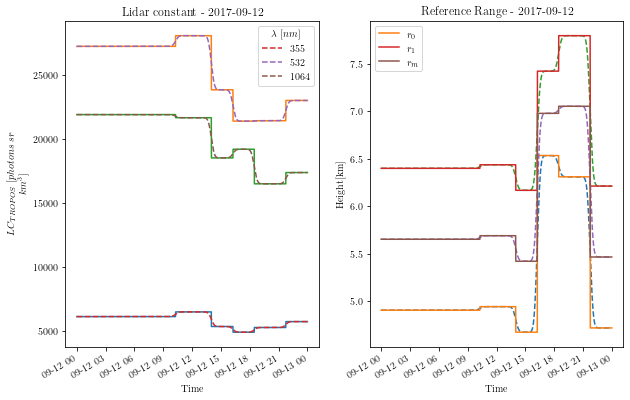

In [5]:
# %%
ds_smooth = ds_day.apply(func = gaussian_filter1d,sigma=30,keep_attrs =True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax = axes.ravel()
ds_day.LC.plot(x='Time',hue='Wavelength',ax=ax[0])
ds_smooth.LC.plot(x='Time',hue='Wavelength',ax=ax[0],linestyle='--')#,colors =['b','g','r'])
"""for l,c in zip(ax[0].lines,['b','g','r','b','g','r']):
	l.set_color(c)

ax[0].legend(ax[0].lines[0:3],ds_day.Wavelength.values)
"""
ax[0].set_title(f'Lidar constant - {day_str}')
for r in ['r0','r1','rm']:
	ds_smooth[r].sel(Wavelength=355).plot(ax=ax[1],linestyle='--')
	ds_day[r].sel(Wavelength=355).plot(label=ds_day[r].long_name,ax=ax[1])
ax[1].set_title(f'Reference Range - {day_str}')
ax[1].set_ylabel('Height[km]')
plt.legend()
plt.show()
# %%

In [6]:
# %%
month_folder_mol = prep.get_month_folder_name ( station.molecular_dataset , day )
month_folder_aer = prep.get_month_folder_name ( station.lidar_dataset , day )
mol_file_name = prep.get_prep_dataset_file_name ( station , day , data_source = 'molecular',lambda_nm = 'all', file_type = 'all' )
aer_file_name = prep.get_prep_dataset_file_name ( station , day , data_source = 'lidar',lambda_nm = 'all', file_type = 'all' )
mol_ds = prep.load_dataset(os.path.join(month_folder_mol,mol_file_name))
aer_ds = prep.load_dataset(os.path.join(month_folder_aer,aer_file_name))
mol_ds['Height']= aer_ds.Height # This is to make sure that Height indexes are the same! otherwise math operations of xarray will not work
# %%

2. Show $pr^2$, $\sigma_m$, $\beta_m$

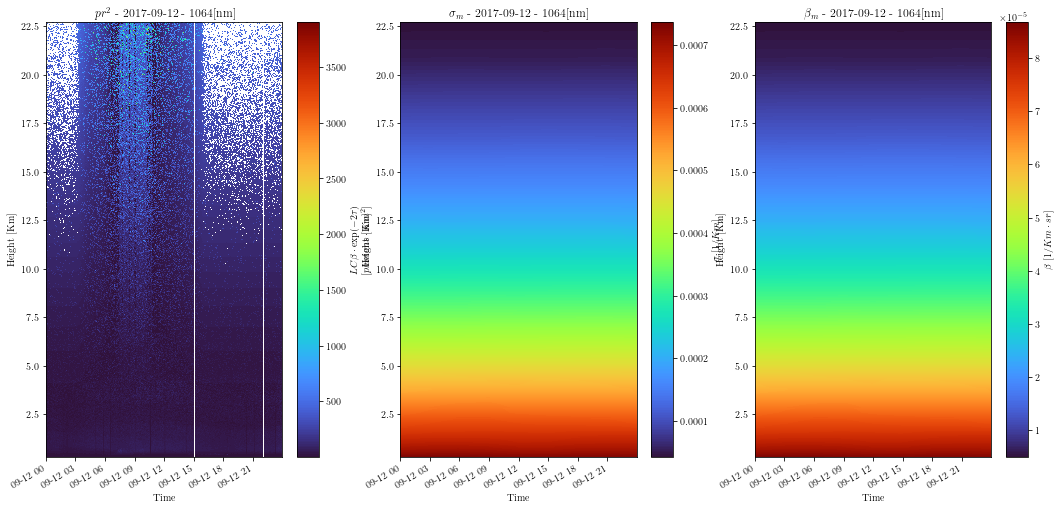

In [7]:
# %%
wavelength = 1064
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
ax = axes.ravel()
aer_ds.range_corr.where(aer_ds.range_corr>0).sel(Wavelength=532).plot(ax = ax[0],cmap='turbo')
mol_ds.sigma.sel(Wavelength=wavelength).plot(ax = ax[1],cmap='turbo')
mol_ds.beta.sel(Wavelength=wavelength).plot(ax = ax[2],cmap='turbo')
for ax,stitle in zip(axes.ravel(),[r'$pr^2$', r'$\sigma_m$', r'$\beta_m$']):
	ax.set_title(f'{stitle} - {day_str} - {wavelength}[nm]')
plt.show()
# %%

To synthesize daily $\sigma$ and $\beta$ profiles, for each wavelength $\lambda$ and day $d$:
1. Set the interesting layer of aerosol to be as $[0.0,r_{max}]$, where 0.0 - is relative to lidar height (not sea level!), $r_{max} = max(r_1), \forall t\in d$
> Note: extend the slicing such that it take into account a map (as in segmentation)

In [8]:
# %%
r_min = ds_day.r0.min().item()
r_max = ds_day.r1.max().item()
r_mid = 0.5*(r_max+r_min)
layer_0 = slice(0.0,r_min + 0.25*(r_mid-r_min))# slice(0.0,r_min*1.3)
layer_1 = slice(0.75*r_min,r_mid) #slice(r_min*.70,r_max)
layer_2 = slice(r_mid,r_max)
merged_layer = slice(0.0,r_max)
print(f'The interesting Height layer:{merged_layer}[km]')
# %%

The interesting Height layer:slice(0.0, 7.7951533203125, None)[km]


2. Slice $pr^2$, the signal measured, up to $r_{max}$.

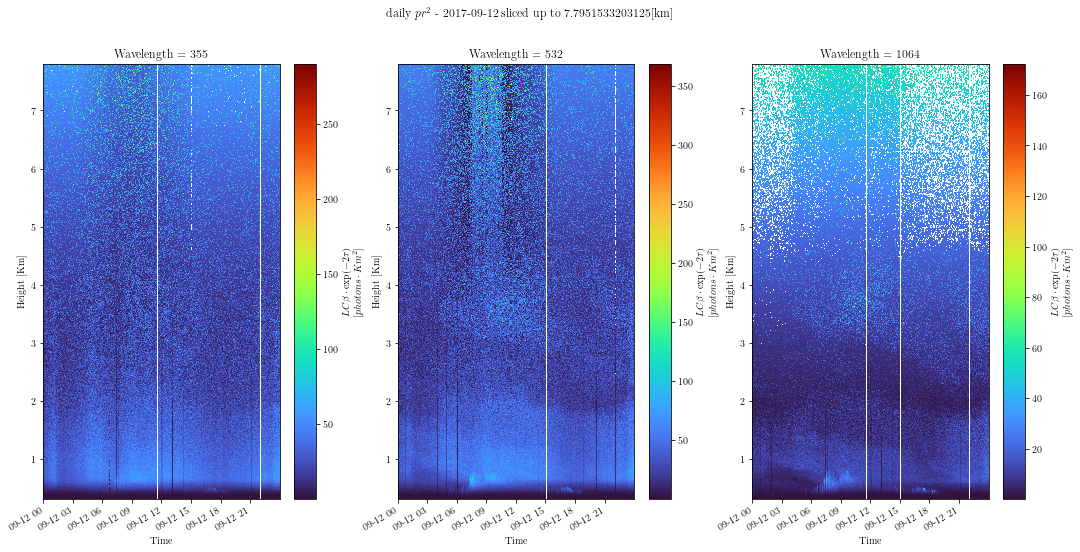

In [9]:
# %%
pr2_merged_layer = aer_ds.range_corr.where(aer_ds.range_corr>0).sel(Height =merged_layer).copy(deep=True)# slice(0.0,9.6480751953125)).copy(deep=True)
pr2_merged_layer.name = r'$pr^2$'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer.sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily $pr^2$ - {day_str} sliced up to {r_max}[km]')
plt.show()

In [10]:
# %% Slice the molecular signal
sigma_merged_layer = mol_ds.sigma.sel(Height =merged_layer).copy(deep=True)
# %%

3. Create a mask with zeros on bins with negative values, and time slots that were not analysed (such clouds or calibration periods)
> TBD

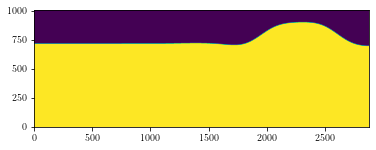

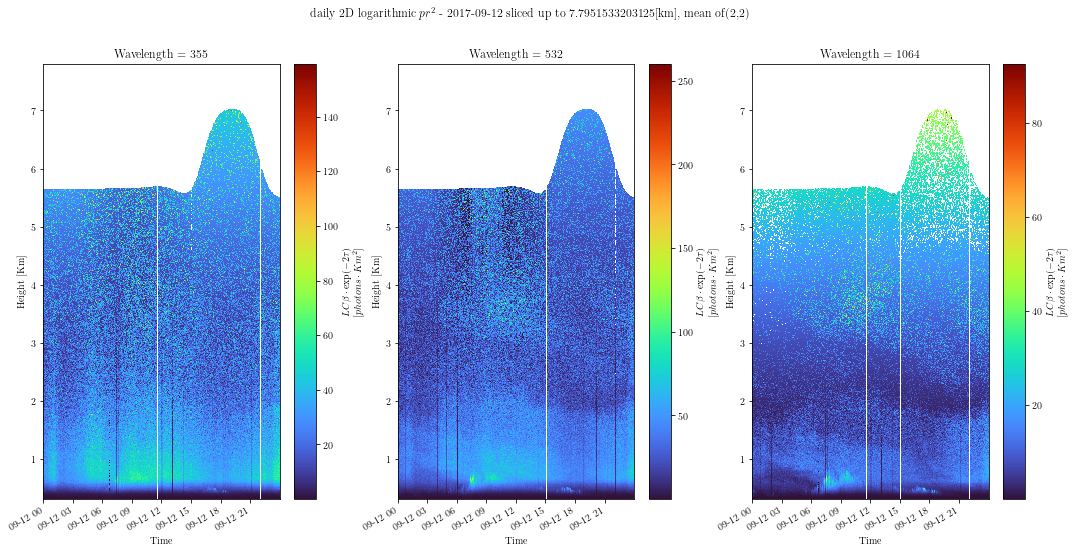

In [11]:
# %%
cut_r0 = ds_day.apply(func = gaussian_filter1d,sigma=120,keep_attrs =True).rm
mask_rm = pr2_merged_layer.Height.where(pr2_merged_layer.Height<= cut_r0).sel(Wavelength=532).values #.sel(Wavelength =1064)
mask_rm[~np.isnan(mask_rm)] = 1.0
mask_rm[np.isnan(mask_rm)] = 0.0
plt.figure()
plt.imshow(mask_rm)
plt.gca().invert_yaxis()
plt.show()
mask_rm = mask_rm.astype(bool)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer.where(mask_rm==True).sel(Wavelength = wavelength).plot(cmap='turbo',ax =ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.show()

# %%

4. Klett inversion :
	- Calculating logarithmic range corrected power
	- $\forall t\in d$ calculate $\sigma$ using KLETT inversion method (using $Pr^2$, $\sigma _m$, $r _{mid}$)
	- This is relevant mainly to $r<=r_{max}$. Since this is a generation process.
	- TODO: check the proccess for using data saved as float64 (currently there are numerical issues)
	> Make sure to do the calculation only on "reading" time slots

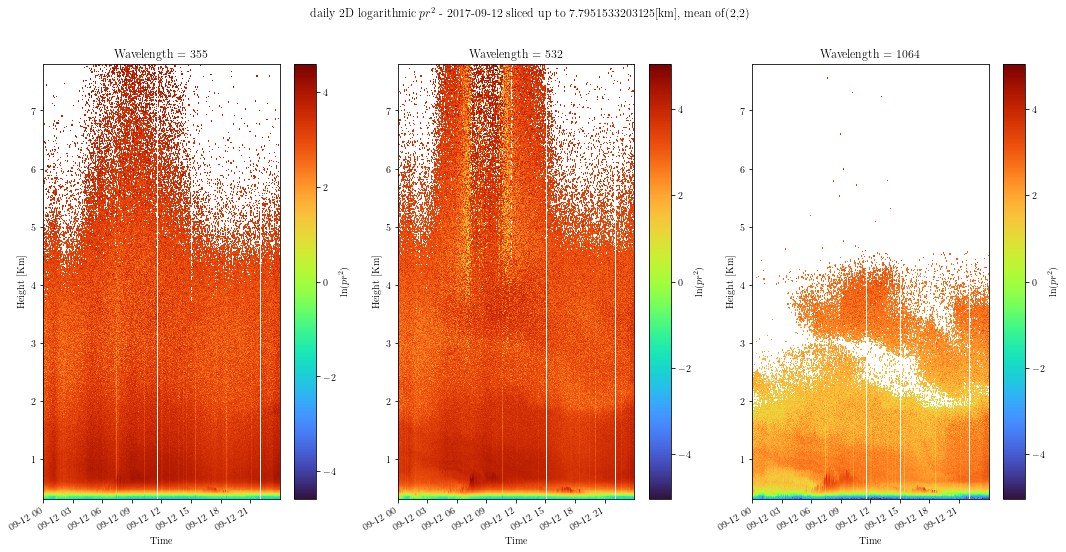

In [12]:
# %%
S = xr.apply_ufunc(lambda x: np.log(x),pr2_merged_layer )
S.name= r'$\ln(pr^2)$'
S_mean = S.rolling(Height = 2,Time =2, center = True).mean()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	S_mean.sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.show()
# %%

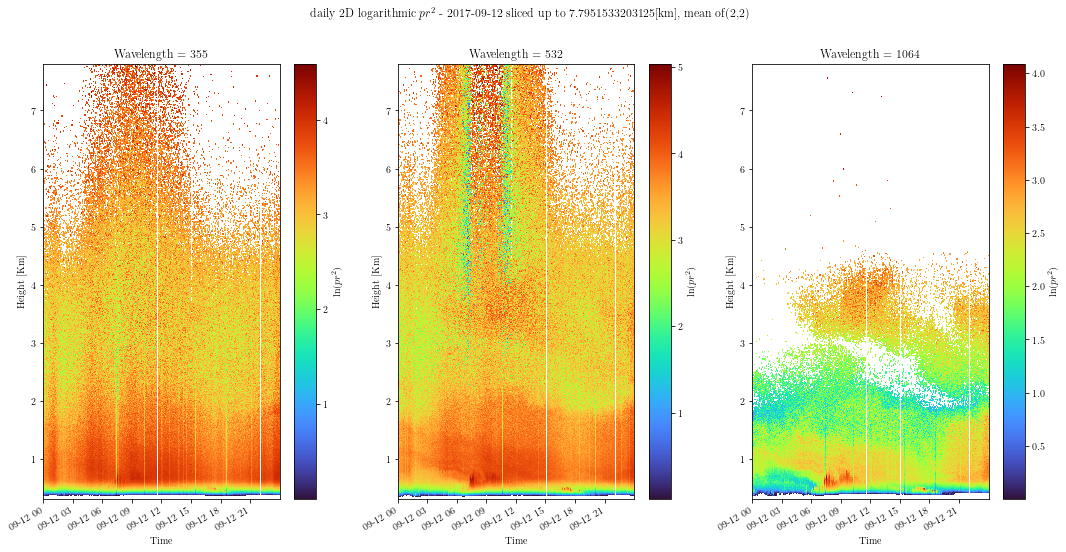

In [13]:
# %%
mask_s = S_mean.where(S_mean>=0.0).values
mask_s[~np.isnan(mask_s)] = 1.0
mask_s[np.isnan(mask_s)] = 0.0
mask_s = mask_s.astype(bool)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
for ind,(wavelength,ax) in enumerate(zip(wavelengths,axes.ravel())):
	S_mean.loc[dict(Wavelength=wavelength)].values[~mask_s[ind]]=eps
	S_mean.where(S_mean>eps).sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.show()
# %%

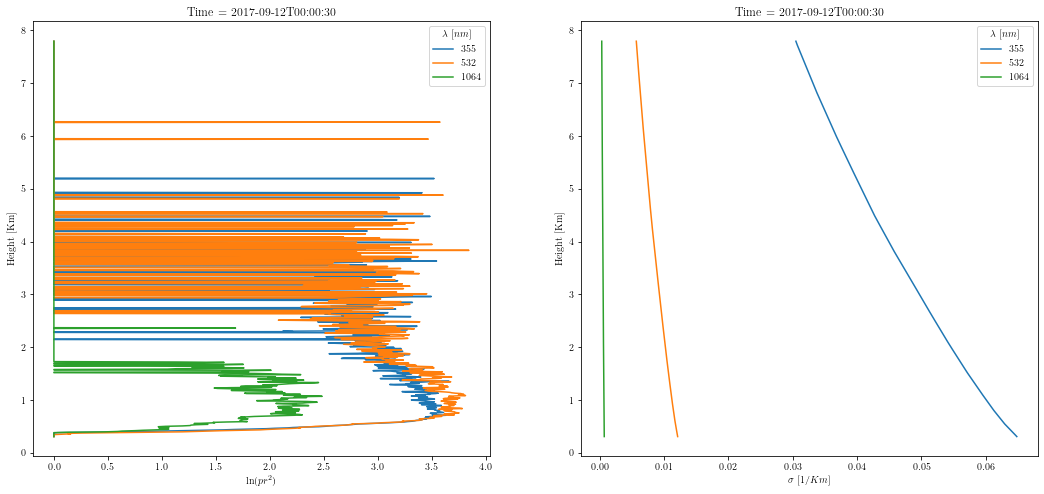

In [14]:
alt_km = station.altitude*1e-3
heights = pr2_merged_layer.Height.values - alt_km
dr = heights[1]-heights[0]
wavelength = 1064
t  = ds_day.Time.values[1]
ind_m =int(ds_day.bin_rm.sel( Time =t,Wavelength=wavelength).values.item())
sigma_t = sigma_merged_layer.sel(Time= t)
S_t = S_mean.sel(Time= t)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = axes.ravel()
S_t.plot(y='Height',ax=ax[0],hue='Wavelength')
sigma_t.plot(y='Height',ax=ax[1],hue='Wavelength')
plt.show()

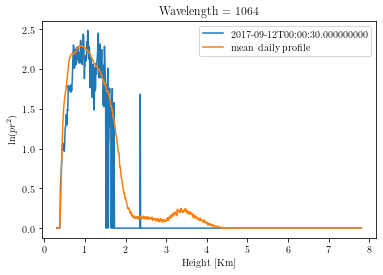

In [15]:
S_mean.sel(Wavelength = wavelength,Time= ds_day.Time.values[1]).plot(label = fr'{t}')
S_mean.mean(dim='Time').sel(Wavelength = wavelength).plot(label='mean daily profile')
plt.legend()
plt.show()

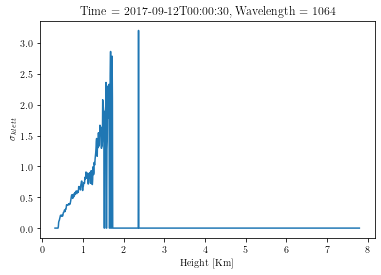

In [16]:
sigma_klett = xr.apply_ufunc(lambda x,y: calc_extiction_klett(np.log(x),heights,y,ind_m),
                             S_t.sel(Wavelength = wavelength),S_t.sel(Wavelength = wavelength))
sigma_klett.name = r'$\sigma_{klett}$'
sigma_klett.plot()
plt.show()

In [17]:
sigma_klett
sigma_klett.min()

<xarray.DataArray '$\\sigma_{klett}$' ()>
array(4.3013038e-17, dtype=float32)
Coordinates:
    Time        datetime64[ns] 2017-09-12T00:00:30
    Wavelength  uint64 1064

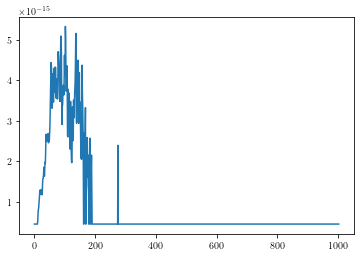

array([4.440892e-16, 4.440892e-16, 4.440892e-16, ..., 4.440892e-16,
       4.440892e-16, 4.440892e-16], dtype=float32)

In [18]:
sigma_klett = calc_extiction_klett(S_t.sel(Wavelength = wavelength).values, heights, S_t.sel(Wavelength = wavelength).values, ind_m)
plt.figure()
plt.plot(sigma_klett)
plt.show()
sigma_klett

5. calculate the aerosol extiction: $\sigma_a(r) = \sigma(r) - \sigma _m(r)$
6. Assume the lidar ratio to be a constant $LR=50[sr]$, and use it to to calculate $\beta_a = \frac{\sigma_a}{LR}$
    > Note: 1. Later make a varying LR through height and time
    >
	> Note: 2. validate that the ratio is defined well
7. "Manipulating" aerosol values:
	- Start from $\lambda=1064[nm]$ since the signal is less affected by the molecular scattering. Then normalize it, and multiply with maximum values of the TROPOS retreival for each wavelength.
	- $\forall r\in [r_{min}, r_{max}]$: reduce dramatically the values of $\sigma_a(r)$ and $\beta_a(r)$
	- $\forall r>r_{max}$: zero the values of $\sigma_a(r)$ and $\beta_a(r)$
	- "Fill in" the missing values of the mask using 2D interpolation & gaussian smoothing
	> Note: "inpainting" can improve the outcome.
9. Add the molecular profile as follows: $\sigma = \sigma_a + \sigma_m$, $\beta = \beta_a + \beta_m$ .
10. create "heatmap" of  reference range, starting from where tha aerosols are 10% of the total extinction/backscatter coefficient.
11. Calculate a new Lidar signal $p$, by using the smoothed $LC$ values during the day (see ds_smooth above)
12. Create a mean background noise $<p_{bg}>$, using previous calculation
> Note: Later change the values according to sun rise and sun set times , and change also the maximum height of the gaussian curve
13. Calculate a new signal $p_{new} \sim Poiss (p_{std}) $,  such that $p_{std} = \sqrt p + <p_{bg}>$
